<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/DistillBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and importing the required packages**

In [36]:
!pip install transformers
!pip install tensorflow_addons

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf 
from transformers import  TFDistilBertModel
from transformers import DistilBertTokenizerFast, DistilBertConfig
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

**Downloading and initializing the tokenizer**

In [38]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

**Loading Data**

In [39]:
# Read the file IMDB Dataset.csv.zip as a pandas dataframe
df = pd.read_excel("Sexism in workplace.xlsx")

In [40]:
df.head()

,Sentences,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


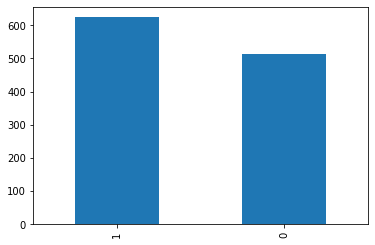

In [41]:
df['Label'].value_counts().plot(kind='bar')

**Train-validation-test split**

In [42]:
# Split the data into train and test subsets
# Stratify the split by the label
# Set the train_size as 0.2 and test_size as 0.2 as the tokenizer is slow
train_index, test_index = train_test_split(df.index, test_size=0.2, shuffle=True)
df_fit= df.loc[train_index]
df_test= df.loc[test_index]

In [43]:
train_index, val_index = train_test_split(df_fit.index, test_size=0.1, shuffle=True)
df_train= df_fit.loc[train_index]
df_val= df_fit.loc[val_index]

In [44]:
X_train=list(df_train.Sentences)
X_val=list(df_val.Sentences)
X_test=list(df_test.Sentences)


y_train=list(df_train.Label)
y_val=list(df_val.Label)
y_test=list(df_test.Label)

**Tokenizing the Sentences and returning the input ids and attention masks which is the combined input to BERT**

In [45]:
def batch_encode(tokenizer, texts, batch_size=128, max_length=50):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="tf", padding = 'max_length', max_length= max_length, truncation= True)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
      
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [46]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val)

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

**Taking the hidden state of DistillBERT's last embedding layer and getting only the sentence embeddings (specifically the CLS token of the last layer which has information about sentence)**




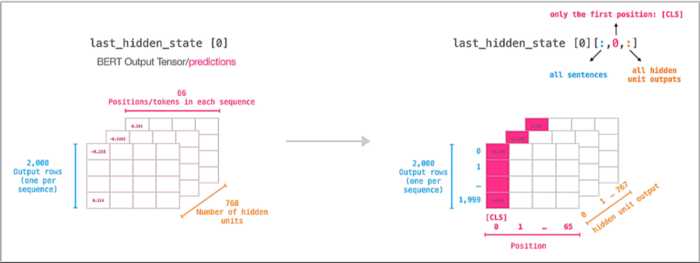




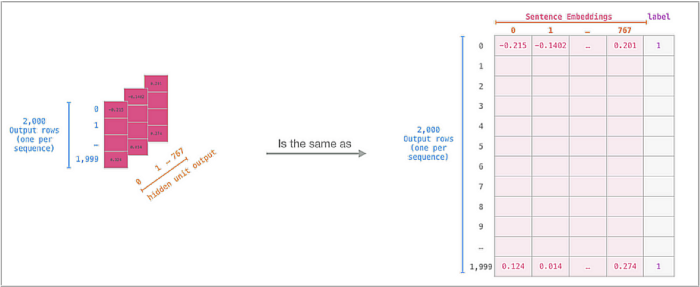

Source of images:
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [47]:

def build_model(transformer, max_length=50):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    #last_hidden_state = transformer([input_ids_layer])[0]
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    D1 = tf.keras.layers.Dropout(0.2, seed=42)(cls_token)
    
    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(0.2, seed=42)(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)

                            
    D3 = tf.keras.layers.Dropout(0.2, seed=42)(X)

    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate= 5e-5), loss='bce', metrics=['accuracy'])#)
    return model

In [48]:
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.1, 
                          output_hidden_states=False, output_attentions=False,return_dict =True)

distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**The overall model architecture is TFDistillBert with a custom classification head of Dense(256), Dense(32), Dense(1 with sigmoid activation) and dropout of 0.2 in between.**

In [49]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model_2[0][0

**Model training for Frozen DistillBert with classification head**

In [50]:
# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_train),
    epochs = 10,
    batch_size = 32,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)

Epoch 1/10
26/26 [==============================] - 8s 118ms/step - loss: 0.7268 - accuracy: 0.4841 - val_loss: 0.6869 - val_accuracy: 0.5275
Epoch 2/10
26/26 [==============================] - 2s 63ms/step - loss: 0.6966 - accuracy: 0.5575 - val_loss: 0.6695 - val_accuracy: 0.5385
Epoch 3/10
26/26 [==============================] - 2s 63ms/step - loss: 0.6805 - accuracy: 0.5709 - val_loss: 0.6411 - val_accuracy: 0.5934
Epoch 4/10
26/26 [==============================] - 2s 63ms/step - loss: 0.6388 - accuracy: 0.6296 - val_loss: 0.6271 - val_accuracy: 0.6154
Epoch 5/10
26/26 [==============================] - 2s 64ms/step - loss: 0.6347 - accuracy: 0.6418 - val_loss: 0.6051 - val_accuracy: 0.6703
Epoch 6/10
26/26 [==============================] - 2s 63ms/step - loss: 0.6216 - accuracy: 0.6724 - val_loss: 0.5906 - val_accuracy: 0.6923
Epoch 7/10
26/26 [==============================] - 2s 64ms/step - loss: 0.5951 - accuracy: 0.7029 - val_loss: 0.5637 - val_accuracy: 0.7253
Epoch 8/10
2

**Unfreeze DistilBERT weights to enable fine-tuning and training**

In [51]:
for layer in distilBERT.layers:
    layer.trainable = True

# Lower the learning rate to prevent destruction of pre-trained weights
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# Recompile model after unfreezing
model.compile(optimizer=optimizer, 
              loss='bce',
              metrics=['accuracy'])#tfa.metrics.F1Score(num_classes=2, average='micro'))
print(model.summary())

# Train the model
train_history2 = model.fit(x = [X_train_ids, X_train_attention],
    y = np.array(y_train),
    epochs = 3,
    batch_size = 32,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)
    

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model_2[0][0

**Trying the model on test data**

In [54]:
loss, accuracy = model.evaluate([X_test_ids, X_test_attention], np.array(y_test))
print("test loss: ", loss)
print("test accuracy: ", accuracy)

8/8 [==============================] - 0s 56ms/step - loss: 0.2507 - accuracy: 0.8991
test loss:  0.2507471442222595
test accuracy:  0.8991228342056274
